In [1]:
import zipfile
import os
import json
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
ZIP_ROOT = '/Users/sm/Downloads/차선-횡단보도 인지 영상(수도권)/Training'
zip_list = [i for i in os.listdir(ZIP_ROOT) if i.endswith('.zip')]
zip_list = sorted(zip_list)
# remove later
print(zip_list)
zip_list = zip_list[:-3]
print(zip_list)

['[라벨]1920_1080_night_train_d_1.zip', '[라벨]d_1920_1080_daylight_train_1.zip', '[라벨]d_1920_1080_daylight_train_10.zip', '[라벨]d_1920_1080_daylight_train_11.zip', '[라벨]d_1920_1080_daylight_train_12.zip', '[라벨]d_1920_1080_daylight_train_13.zip', '[라벨]d_1920_1080_daylight_train_14.zip', '[라벨]d_1920_1080_daylight_train_15.zip', '[라벨]d_1920_1080_daylight_train_16.zip', '[라벨]d_1920_1080_daylight_train_2.zip', '[라벨]d_1920_1080_daylight_train_3.zip', '[라벨]d_1920_1080_daylight_train_4.zip', '[라벨]d_1920_1080_daylight_train_5.zip', '[라벨]d_1920_1080_daylight_train_6.zip', '[라벨]d_1920_1080_daylight_train_7.zip', '[라벨]d_1920_1080_daylight_train_8.zip', '[라벨]d_1920_1080_daylight_train_9.zip', '[원천]d_1920_1080_daylight_train_1.zip', '[원천]d_1920_1080_daylight_train_10.zip', '[원천]d_1920_1080_daylight_train_2.zip']
['[라벨]1920_1080_night_train_d_1.zip', '[라벨]d_1920_1080_daylight_train_1.zip', '[라벨]d_1920_1080_daylight_train_10.zip', '[라벨]d_1920_1080_daylight_train_11.zip', '[라벨]d_1920_1080_daylight_train_12

In [3]:
def coco_form():
    coco_format = dict(
        info=dict(
            year=2021, version="1.0", description="Crosswalk extraction", contributor="AI Hub", url="https://aihub.or.kr/aidata/27675", date_created='2021-12-14 02:39:00'
        ),
        licenses=[
            dict(id=0, name='', url='')
        ],
        categories=[
            dict(id=0, name='background', supercategory=None),
            dict(id=1, name='crosswalk', supercategory=None)
        ],
        images=[
        ],
        annotations=[
        ]
    )

    return coco_format

In [5]:
# 각 annotation.json file 의 구조
# dict_keys(['image', 'annotations'])
# anno['image'] : dict(file_name='', image_size='')
# anno['annotations'] = list(
#                           dict(class='str',
                                #traffic lane 만 존재하는 value 나머지는 빈 리스트값
#                               attributes='dict(code='', value='')',
                                # 횡단보도는 polygon 만 존재 
#                               category='str in ['polyline', 'polygon']', 
#                               data='list(dict(x:='', y=''), dict(x:='', y=''))'
#                               )
# )
coco_format = coco_form()

dataframe_keylist = ['file_locate', 'file_name', 'class', 'coord']
dataframe_value=[]
# error_img = ['15337349', '14994218']
error_img = ['14277614']
get_info = []
# image id index
id_idx = 0
anno_id_idx = 0

for zip_file in tqdm(zip_list):
    zip_file_name = zip_file.replace('라벨','원천')
    with zipfile.ZipFile(os.path.join(ZIP_ROOT, zip_file), 'r') as target_zip:
        json_list = target_zip.namelist()
        print(f'{zip_file} start len : {len(json_list)}')
        for json_file in json_list:
            id_idx_flag = False
            with target_zip.open(json_file, 'r') as extract_json:
                json_info = json.load(extract_json)
                if json_file.split('.')[0] in error_img:
                    print(json_info)
                    get_info.append(json_info)
                for anno in json_info['annotations']:
                    # 좌표정보
                    segmentation_coord = []
                    for coordinate in anno['data']:
                        # mapping to 0 under 0
                        x = 0 if coordinate['x'] < 0 else coordinate['x']
                        y = 0 if coordinate['y'] < 0 else coordinate['y']

                        # mapping 1920, 1080 over values
                        x = 1919 if x >=1920 else coordinate['x']
                        y = 1079 if y >=1080 else coordinate['y']

                        segmentation_coord.append([x,y])

                    if anno['class'] == 'crosswalk':
                        #anno info append
                        coco_format['annotations'].append(
                            dict(id=anno_id_idx, image_id=id_idx, category_id=1, bbox=[], area=0, segmentation=segmentation_coord, iscrowd=0)
                            )
                        # anno index +=1
                        anno_id_idx+=1
                        # id add flag set True
                        id_idx_flag = True
                    
                    # dataframe 생성용도(검증용)
                    dataframe_value.append(
                        [zip_file_name, json_info['image']['file_name'], anno['class'], segmentation_coord]
                        )
                        
                if id_idx_flag:
                    #image info append
                    coco_format['images'].append(
                        dict(license=0, url=None, file_name=json_info['image']['file_name'],
                            height=json_info['image']['image_size'][0], width=json_info['image']['image_size'][1], data_captured=None, id=id_idx)
                            )
                    id_idx+=1
                    


  6%|▌         | 1/17 [00:01<00:21,  1.31s/it][라벨]d_1920_1080_daylight_train_1.zip start len : 15000
{'image': {'file_name': '14277614.jpg', 'image_size': [1080, 1920]}, 'annotations': [{'class': 'traffic_lane', 'attributes': [{'code': 'lane_color', 'value': 'white'}, {'code': 'lane_type', 'value': 'dotted'}], 'category': 'polyline', 'data': [{'x': 388, 'y': 953}, {'x': 640, 'y': 726}]}, {'class': 'traffic_lane', 'attributes': [{'code': 'lane_color', 'value': 'yellow'}, {'code': 'lane_type', 'value': 'solid'}], 'category': 'polyline', 'data': [{'x': 639, 'y': 724}, {'x': 741, 'y': 630}, {'x': 755, 'y': 617}]}, {'class': 'stop_line', 'attributes': [], 'category': 'polyline', 'data': [{'x': 696, 'y': 629}, {'x': 517, 'y': 628}]}, {'class': 'crosswalk', 'attributes': [], 'category': 'polygon', 'data': [{'x': 665, 'y': 622}, {'x': 741, 'y': 626}, {'x': 741, 'y': 608}, {'x': 662, 'y': 608}]}, {'class': 'traffic_lane', 'attributes': [{'code': 'lane_color', 'value': 'yellow'}, {'code': 'lane_

In [6]:
print(len(coco_format['annotations']))

all_df = pd.DataFrame(dataframe_value, columns=dataframe_keylist)
get_dist = all_df[all_df['class'] == 'crosswalk']
get_dist

179417


,file_locate,file_name,class,coord
18,[원천]1920_1080_night_train_d_1.zip,15691903.jpg,crosswalk,"[[1112, 708], [628, 765], [330, 788], [3, 820]..."
40,[원천]1920_1080_night_train_d_1.zip,15484144.jpg,crosswalk,"[[118, 806], [1644, 822], [1914, 817], [1919, ..."
41,[원천]1920_1080_night_train_d_1.zip,15484144.jpg,crosswalk,"[[2, 636], [430, 623], [791, 615], [1343, 598]..."
52,[원천]1920_1080_night_train_d_1.zip,14427380.jpg,crosswalk,"[[6, 639], [552, 587], [378, 572], [7, 578], [..."
53,[원천]1920_1080_night_train_d_1.zip,14427380.jpg,crosswalk,"[[937, 602], [1219, 624], [1579, 653], [1527, ..."
...,...,...,...,...
1683961,[원천]d_1920_1080_daylight_train_9.zip,14548161.jpg,crosswalk,"[[522, 612], [901, 601], [1074, 598], [1149, 6..."
1683962,[원천]d_1920_1080_daylight_train_9.zip,14548161.jpg,crosswalk,"[[1318, 607], [1716, 601], [1716, 666], [1575,..."
1683967,[원천]d_1920_1080_daylight_train_9.zip,14758492.jpg,crosswalk,"[[30, 635], [658, 563], [617, 558], [78, 619]]"
1683968,[원천]d_1920_1080_daylight_train_9.zip,14758492.jpg,crosswalk,"[[1038, 520], [1276, 519], [1913, 515], [1917,..."


In [7]:
# num of annotations
get_dist['file_locate'].value_counts()

[원천]d_1920_1080_daylight_train_2.zip     19492
[원천]d_1920_1080_daylight_train_1.zip     15428
[원천]d_1920_1080_daylight_train_14.zip    13138
[원천]d_1920_1080_daylight_train_8.zip     13120
[원천]d_1920_1080_daylight_train_5.zip     12683
[원천]d_1920_1080_daylight_train_10.zip    12253
[원천]d_1920_1080_daylight_train_13.zip    11885
[원천]d_1920_1080_daylight_train_3.zip     10869
[원천]d_1920_1080_daylight_train_4.zip     10777
[원천]d_1920_1080_daylight_train_15.zip    10577
[원천]d_1920_1080_daylight_train_11.zip     9183
[원천]d_1920_1080_daylight_train_9.zip      8233
[원천]d_1920_1080_daylight_train_12.zip     7701
[원천]d_1920_1080_daylight_train_6.zip      7362
[원천]d_1920_1080_daylight_train_7.zip      6379
[원천]d_1920_1080_daylight_train_16.zip     6115
[원천]1920_1080_night_train_d_1.zip         4222
Name: file_locate, dtype: int64

In [8]:
# num of images
get_dist.groupby('file_locate')['file_name'].count()

file_locate
[원천]1920_1080_night_train_d_1.zip         4222
[원천]d_1920_1080_daylight_train_1.zip     15428
[원천]d_1920_1080_daylight_train_10.zip    12253
[원천]d_1920_1080_daylight_train_11.zip     9183
[원천]d_1920_1080_daylight_train_12.zip     7701
[원천]d_1920_1080_daylight_train_13.zip    11885
[원천]d_1920_1080_daylight_train_14.zip    13138
[원천]d_1920_1080_daylight_train_15.zip    10577
[원천]d_1920_1080_daylight_train_16.zip     6115
[원천]d_1920_1080_daylight_train_2.zip     19492
[원천]d_1920_1080_daylight_train_3.zip     10869
[원천]d_1920_1080_daylight_train_4.zip     10777
[원천]d_1920_1080_daylight_train_5.zip     12683
[원천]d_1920_1080_daylight_train_6.zip      7362
[원천]d_1920_1080_daylight_train_7.zip      6379
[원천]d_1920_1080_daylight_train_8.zip     13120
[원천]d_1920_1080_daylight_train_9.zip      8233
Name: file_name, dtype: int64

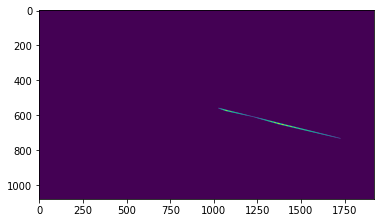

In [72]:
#검증해야함 지금은 문제가 있다고 느껴짐
a = np.zeros([1080,1920])

a = cv2.fillPoly(a, [np.array(segmentation_coord)], (255,0,0))
plt.imshow(a)

In [9]:
save_file_name = 'line_crosswalk_(12_14)'
all_df.to_csv(save_file_name+'.csv',header=True, index=False)
with open(save_file_name+'.json', 'w') as f:
    json.dump(coco_format, f, indent=4)

In [10]:
save_file_name = 'line_crosswalk_(12_14)'
get_dist.to_csv(save_file_name+'_filtered.csv', header=True, index=False, encoding='utf-8')

[0.02141203703703704, 0.026507844650205763, 0.11648019547325103]
# annotations : 3	 detect coordinate : 3


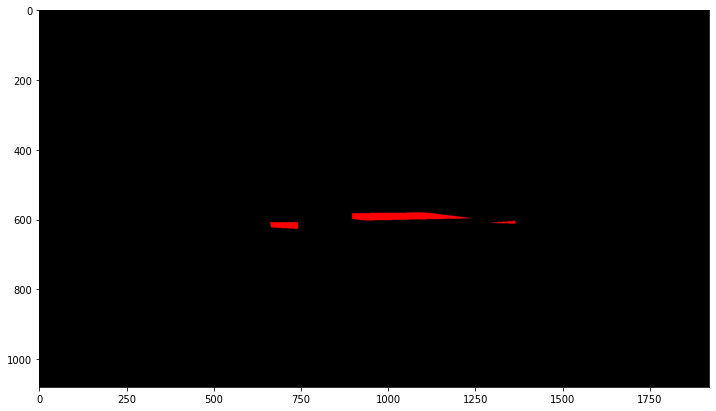

In [48]:
IMG_ROOT ='/Users/sm/Downloads/차선-횡단보도 인지 영상(수도권)/Training/[원천]d_1920_1080_daylight_train_1'

error_coord = []
point = 0

image = cv2.imread(os.path.join(IMG_ROOT, '14277614.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for anno in get_info[0]['annotations']:

    if anno['class'] == 'crosswalk':
        temp = []
        point+=1
        for coord in anno['data']:
            temp.append([coord['x'], coord['y']])

        error_coord.append(np.array(temp))

dummy = np.zeros_like(image)

fillpoly_proportion = []

for i in error_coord:
    dummy = cv2.fillPoly(dummy, [i], 255)
    image = cv2.polylines(image, [i], True, (255,0,0), 5)
    _, counts = np.unique(dummy, return_counts=True)
    fillpoly_proportion.append(counts[-1]/(3*1920*1080)*100)

#여기 있는 성분으로 몇퍼센트 이하의 좌표를 거를건지 확인
print(fillpoly_proportion)
print(f'# annotations : {point}\t detect coordinate : {len(error_coord)}')
plt.figure(figsize=(12,9))
plt.imshow(dummy)


In [9]:
%%timeit

dummy = np.zeros((1080,1920))
dummy = cv2.fillPoly(dummy, [np.array(get_dist.iloc[0]['coord'])], 255)
_, counts = np.unique(dummy, return_counts=True)
# print(round(counts[-1]*100/(1920*1080),2))

80.2 ms ± 727 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
def calculate_area(coord_list):
    dummy = np.zeros((1080,1920))
    dummy = cv2.fillPoly(dummy, [np.array(coord_list)], 255)
    _, counts = np.where(dummy==255)
    return round(len(counts)*100/(1920*1080),2)

# get_dist['area'] = get_dist.apply(calculate_area, axis=1)

In [28]:
for_series = []
for i in tqdm(get_dist['coord'].values):
    for_series.append(calculate_area(i))

  1%|          | 969/179417 [01:17<4:07:18, 12.03it/s]

In [9]:
for_series = []
for i in tqdm(get_dist['coord'].values):
    for_series.append(calculate_area(i))

 28%|██▊       | 51092/179417 [09:10<23:02, 92.83it/s]


error: OpenCV(4.5.4) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/drawing.cpp:2395: error: (-215:Assertion failed) p.checkVector(2, CV_32S) >= 0 in function 'fillPoly'


In [10]:
%load_ext line_profiler

In [29]:
%lprun -f calculate_area calculate_area(get_dist.iloc[0]['coord'])

Timer unit: 1e-06 s

Total time: 0.086156 s
File: /var/folders/h9/r8r6r6md7wsdy0x43cwkg1zm0000gn/T/ipykernel_13386/967336575.py
Function: calculate_area at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def calculate_area(coord_list):
     2         1       1897.0   1897.0      2.2      dummy = np.zeros((1080,1920))
     3         1        124.0    124.0      0.1      dummy = cv2.fillPoly(dummy, [np.array(coord_list)], 255)
     4         1      84096.0  84096.0     97.6      _, counts = np.unique(dummy, return_counts=True)
     5         1         39.0     39.0      0.0      return round(counts[-1]*100/(1920*1080),2)

In [27]:
%lprun -f calculate_area calculate_area(get_dist.iloc[0]['coord'])

Timer unit: 1e-06 s

Total time: 0.018796 s
File: /var/folders/h9/r8r6r6md7wsdy0x43cwkg1zm0000gn/T/ipykernel_13386/2201740890.py
Function: calculate_area at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def calculate_area(coord_list):
     2         1        265.0    265.0      1.4      dummy = np.zeros((1080,1920))
     3         1        878.0    878.0      4.7      dummy = cv2.fillPoly(dummy, [np.array(coord_list)], 255)
     4         1      17628.0  17628.0     93.8      _, counts = np.where(dummy==255)
     5         1         25.0     25.0      0.1      return round(len(counts)*100/(1920*1080),2)

In [23]:
dummy = np.zeros([1080,1920])
a,b = np.where(dummy==0)
print(len(a))
print(len(b))

2073600
2073600


In [10]:
print(get_dist.iloc[51092])

file_locate    [원천]d_1920_1080_daylight_train_13.zip
file_name                               15337349.jpg
class                                      crosswalk
coord                                             []
Name: 465708, dtype: object


In [40]:
target_df = get_dist[get_dist['file_locate'].isin(['[원천]d_1920_1080_daylight_train_2.zip','[원천]d_1920_1080_daylight_train_1.zip'])]
target_df

,file_locate,file_name,class,coord
57251,[원천]d_1920_1080_daylight_train_1.zip,15997436.jpg,crosswalk,"[[651, 619], [874, 618], [1123, 616], [1125, 6..."
57275,[원천]d_1920_1080_daylight_train_1.zip,14509671.jpg,crosswalk,"[[1216, 319], [1470, 259], [1548, 243], [1546,..."
57296,[원천]d_1920_1080_daylight_train_1.zip,14320702.jpg,crosswalk,"[[1500, 614], [1862, 632], [1828, 591], [1544,..."
57298,[원천]d_1920_1080_daylight_train_1.zip,14320702.jpg,crosswalk,"[[466, 656], [1316, 624], [1233, 590], [498, 6..."
57299,[원천]d_1920_1080_daylight_train_1.zip,14320702.jpg,crosswalk,"[[1185, 516], [1327, 567], [1481, 559], [1296,..."
...,...,...,...,...
987878,[원천]d_1920_1080_daylight_train_2.zip,14233338.jpg,crosswalk,"[[1120, 624], [1566, 586], [1901, 583], [1913,..."
987879,[원천]d_1920_1080_daylight_train_2.zip,14233338.jpg,crosswalk,"[[0, 650], [873, 620], [935, 630], [0, 663]]"
987912,[원천]d_1920_1080_daylight_train_2.zip,16172288.jpg,crosswalk,"[[50, 666], [114, 670], [413, 664], [569, 659]..."
987918,[원천]d_1920_1080_daylight_train_2.zip,14317523.jpg,crosswalk,"[[1311, 569], [1353, 579], [1353, 569], [1318,..."


In [41]:
for_series = []
for i in tqdm(target_df['coord'].values):
    for_series.append(calculate_area(i))

100%|██████████| 34920/34920 [06:34<00:00, 88.52it/s]


<AxesSubplot:ylabel='Density'>

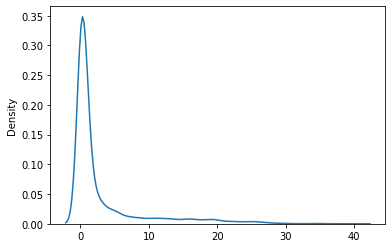

In [19]:
import seaborn as sns
sns.kdeplot(sorted(for_series))

In [42]:
target_df['ratio'] = for_series
target_df.to_csv('line_crosswalk_with_ratio_(12_14).csv', index=False, header=True, encoding='utf-8')
target_df = target_df[target_df['ratio']>=20]
target_df

/var/folders/h9/r8r6r6md7wsdy0x43cwkg1zm0000gn/T/ipykernel_15032/3528579099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['ratio'] = for_series


,file_locate,file_name,class,coord,ratio
57398,[원천]d_1920_1080_daylight_train_1.zip,15983778.jpg,crosswalk,"[[1, 973], [0, 703], [268, 709], [717, 721], [...",26.66
57536,[원천]d_1920_1080_daylight_train_1.zip,14507787.jpg,crosswalk,"[[7, 1073], [2, 860], [429, 768], [1099, 622],...",34.66
57881,[원천]d_1920_1080_daylight_train_1.zip,14540806.jpg,crosswalk,"[[1453, 714], [1832, 720], [1917, 744], [1919,...",28.94
57979,[원천]d_1920_1080_daylight_train_1.zip,16007664.jpg,crosswalk,"[[187, 665], [256, 698], [326, 729], [439, 807...",21.69
57991,[원천]d_1920_1080_daylight_train_1.zip,15887524.jpg,crosswalk,"[[4, 598], [0, 777], [266, 855], [1280, 982], ...",24.46
...,...,...,...,...,...
985712,[원천]d_1920_1080_daylight_train_2.zip,14208145.jpg,crosswalk,"[[1907, 759], [1913, 1073], [4, 1073], [5, 804]]",26.90
986252,[원천]d_1920_1080_daylight_train_2.zip,16135081.jpg,crosswalk,"[[1918, 932], [1622, 943], [1366, 949], [1089,...",20.32
986514,[원천]d_1920_1080_daylight_train_2.zip,16129491.jpg,crosswalk,"[[882, 754], [1713, 782], [1916, 795], [1919, ...",22.84
987233,[원천]d_1920_1080_daylight_train_2.zip,14207215.jpg,crosswalk,"[[4, 713], [925, 686], [1571, 703], [1798, 725...",27.51


In [28]:
target_df['file_name'].unique

<bound method Series.unique of 57398     15983778.jpg
57536     14507787.jpg
57881     14540806.jpg
57979     16007664.jpg
57991     15887524.jpg
              ...     
985712    14208145.jpg
986252    16135081.jpg
986514    16129491.jpg
987233    14207215.jpg
987848    16139185.jpg
Name: file_name, Length: 1155, dtype: object>

In [43]:
temp_dist = get_dist[get_dist['file_name'].isin(target_df['file_name'].values)]
temp_dist

,file_locate,file_name,class,coord
57398,[원천]d_1920_1080_daylight_train_1.zip,15983778.jpg,crosswalk,"[[1, 973], [0, 703], [268, 709], [717, 721], [..."
57536,[원천]d_1920_1080_daylight_train_1.zip,14507787.jpg,crosswalk,"[[7, 1073], [2, 860], [429, 768], [1099, 622],..."
57537,[원천]d_1920_1080_daylight_train_1.zip,14507787.jpg,crosswalk,"[[89, 683], [286, 630], [268, 611], [91, 657]]"
57538,[원천]d_1920_1080_daylight_train_1.zip,14507787.jpg,crosswalk,"[[60, 738], [198, 673], [62, 711]]"
57881,[원천]d_1920_1080_daylight_train_1.zip,14540806.jpg,crosswalk,"[[1453, 714], [1832, 720], [1917, 744], [1919,..."
...,...,...,...,...
986514,[원천]d_1920_1080_daylight_train_2.zip,16129491.jpg,crosswalk,"[[882, 754], [1713, 782], [1916, 795], [1919, ..."
987233,[원천]d_1920_1080_daylight_train_2.zip,14207215.jpg,crosswalk,"[[4, 713], [925, 686], [1571, 703], [1798, 725..."
987846,[원천]d_1920_1080_daylight_train_2.zip,16139185.jpg,crosswalk,"[[557, 616], [558, 626], [1059, 618], [1310, 6..."
987847,[원천]d_1920_1080_daylight_train_2.zip,16139185.jpg,crosswalk,"[[1480, 620], [1628, 638], [1778, 630], [1778,..."


In [45]:
under_ratio_dist = temp_dist[temp_dist['coord'].isin(target_df['coord'].values)==False]
under_ratio_dist

,file_locate,file_name,class,coord
57537,[원천]d_1920_1080_daylight_train_1.zip,14507787.jpg,crosswalk,"[[89, 683], [286, 630], [268, 611], [91, 657]]"
57538,[원천]d_1920_1080_daylight_train_1.zip,14507787.jpg,crosswalk,"[[60, 738], [198, 673], [62, 711]]"
57882,[원천]d_1920_1080_daylight_train_1.zip,14540806.jpg,crosswalk,"[[1002, 531], [1016, 531], [1016, 536], [950, ..."
57978,[원천]d_1920_1080_daylight_train_1.zip,16007664.jpg,crosswalk,"[[-1, 635], [102, 639], [105, 655], [0, 655]]"
58019,[원천]d_1920_1080_daylight_train_1.zip,15739678.jpg,crosswalk,"[[1317, 667], [1436, 659], [1695, 628], [1829,..."
...,...,...,...,...
986255,[원천]d_1920_1080_daylight_train_2.zip,16135081.jpg,crosswalk,"[[1882, 654], [1842, 648], [1711, 630], [1623,..."
986263,[원천]d_1920_1080_daylight_train_2.zip,16135081.jpg,crosswalk,"[[714, 608], [745, 608], [903, 603], [957, 601..."
986265,[원천]d_1920_1080_daylight_train_2.zip,16135081.jpg,crosswalk,"[[0, 639], [71, 631], [0, 629]]"
987846,[원천]d_1920_1080_daylight_train_2.zip,16139185.jpg,crosswalk,"[[557, 616], [558, 626], [1059, 618], [1310, 6..."


In [35]:
for_series = []
for i in tqdm(temp_dist[temp_dist['coord'].isin(target_df['coord'].values)==False]['coord'].values):
    for_series.append(calculate_area(i))

100%|██████████| 1112/1112 [00:13<00:00, 85.03it/s]


<AxesSubplot:ylabel='Density'>

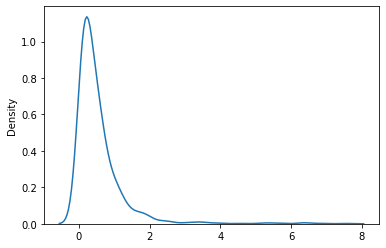

In [37]:
sns.kdeplot(sorted(for_series))

In [ ]:
temp_dist[temp_dist['coord'].isin(target_df['coord'].values)==False]['coord'].values

In [53]:
target_df[target_df['file_name'].isin(under_ratio_dist['file_name'].values)==False]

,file_locate,file_name,class,coord,ratio
57398,[원천]d_1920_1080_daylight_train_1.zip,15983778.jpg,crosswalk,"[[1, 973], [0, 703], [268, 709], [717, 721], [...",26.66
57991,[원천]d_1920_1080_daylight_train_1.zip,15887524.jpg,crosswalk,"[[4, 598], [0, 777], [266, 855], [1280, 982], ...",24.46
58357,[원천]d_1920_1080_daylight_train_1.zip,14418939.jpg,crosswalk,"[[5, 958], [737, 937], [1618, 904], [1913, 886...",22.44
58936,[원천]d_1920_1080_daylight_train_1.zip,14418918.jpg,crosswalk,"[[107, 946], [724, 937], [1908, 881], [1915, 6...",21.79
59149,[원천]d_1920_1080_daylight_train_1.zip,14517242.jpg,crosswalk,"[[4, 769], [563, 657], [1248, 508], [1916, 367...",31.29
...,...,...,...,...,...
984368,[원천]d_1920_1080_daylight_train_2.zip,14229926.jpg,crosswalk,"[[2, 995], [559, 1012], [1221, 1021], [1773, 1...",24.80
984801,[원천]d_1920_1080_daylight_train_2.zip,14229920.jpg,crosswalk,"[[2, 994], [548, 1012], [1256, 1026], [1914, 1...",24.97
985083,[원천]d_1920_1080_daylight_train_2.zip,14297568.jpg,crosswalk,"[[8, 975], [9, 975], [419, 1009], [1609, 1012]...",22.72
986514,[원천]d_1920_1080_daylight_train_2.zip,16129491.jpg,crosswalk,"[[882, 754], [1713, 782], [1916, 795], [1919, ...",22.84
